In [18]:
from load import load_dataset
import networkx as nx
from torch_geometric.utils import to_networkx
from tqdm import tqdm
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import tabulate
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

In [30]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embeddings_dim = 384
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_loader, val_loader = load_dataset(tokenizer, batch_size=1)

# check that all graphs are undirected and connected
for g in tqdm(train_loader):
    graph = to_networkx(g)
    assert np.all(graph.adj == np.transpose(graph.adj))

100%|██████████| 26408/26408 [01:04<00:00, 407.50it/s]


In [28]:
# compute key metrics
number_of_nodes = []
number_of_edges = []
average_degree = []
diameter = []
average_closeness_centrality = []
is_connected = []
for g in tqdm(train_loader):
    graph = to_networkx(g, to_undirected=True)
    number_of_nodes.append(graph.number_of_nodes())
    number_of_edges.append(graph.number_of_edges())
    average_degree.append(sum(dict(graph.degree()).values()) / graph.number_of_nodes())
    average_closeness_centrality.append(
        sum(nx.closeness_centrality(graph).values()) / graph.number_of_nodes()
    )
    connection = nx.is_connected(graph)
    if connection:
        is_connected.append(True)
        diameter.append(nx.diameter(graph))
    else:
        is_connected.append(False)
        diameter.append(None)

100%|██████████| 26408/26408 [02:03<00:00, 214.68it/s]


In [29]:
print("Ratio of connected graphs:", sum(is_connected) / len(is_connected))

data = [
    ["", "Mean", "Std", "Min", "Max"],
    [
        "Number of nodes",
        *pd.Series(number_of_nodes).describe()[["mean", "std", "min", "max"]],
    ],
    [
        "Number of edges",
        *pd.Series(number_of_edges).describe()[["mean", "std", "min", "max"]],
    ],
    [
        "Average degree",
        *pd.Series(average_degree).describe()[["mean", "std", "min", "max"]],
    ],
    ["Diameter", *pd.Series(diameter).describe()[["mean", "std", "min", "max"]]],
    [
        "Average closeness centrality",
        *pd.Series(average_closeness_centrality).describe()[
            ["mean", "std", "min", "max"]
        ],
    ],
]
table = tabulate.tabulate(data, tablefmt="html")
table

Ratio of connected graphs: 0.9545970917903666


'<table>\n<tbody>\n<tr><td>                            </td><td>Mean               </td><td>Std                </td><td>Min</td><td>Max  </td></tr>\n<tr><td>Number of nodes             </td><td>32.292676461678276 </td><td>29.163173039029633 </td><td>1.0</td><td>536.0</td></tr>\n<tr><td>Number of edges             </td><td>33.591676764616786 </td><td>31.1554153029334   </td><td>0.0</td><td>599.0</td></tr>\n<tr><td>Average degree              </td><td>2.0332326230005955 </td><td>0.2176064904308681 </td><td>0.0</td><td>2.5  </td></tr>\n<tr><td>Diameter                    </td><td>16.5914554325836   </td><td>13.01771337875436  </td><td>0.0</td><td>218.0</td></tr>\n<tr><td>Average closeness centrality</td><td>0.21440356000797053</td><td>0.11875822010240816</td><td>0.0</td><td>1.0  </td></tr>\n</tbody>\n</table>'

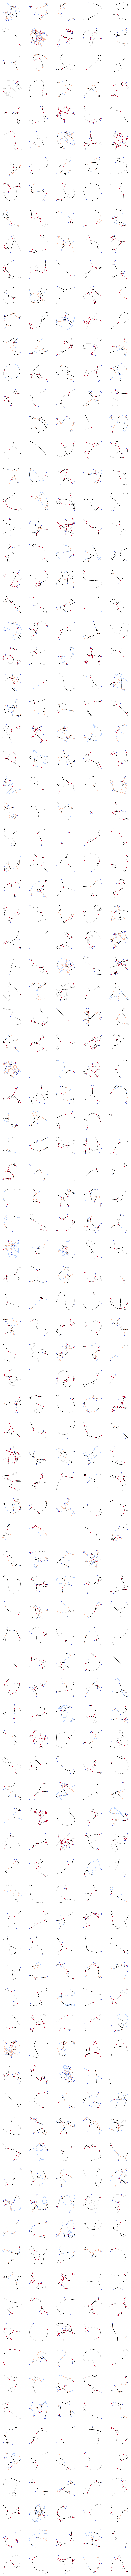

In [40]:
# Visualize a few graphs

nrows = 100

fig, ax = plt.subplots(nrows, 5, figsize=(20, 4 * nrows))

for i, g in enumerate(train_loader):
    graph = to_networkx(g, to_undirected=True)
    pos = nx.spring_layout(graph)
    node_color = [graph.degree(v) for v in graph]
    node_size = [graph.degree(v) * 10 for v in graph]
    m = cm.ScalarMappable(norm=Normalize(vmin=min(node_color), vmax=max(node_color)))
    m.set_array([])
    _ = nx.draw_networkx(
        graph,
        pos=pos,
        node_size=node_size,
        node_color=node_color,
        cmap=plt.get_cmap("coolwarm"),
        with_labels=False,
        ax=ax[i // 5, i % 5],
    )
    ax[i // 5, i % 5].set_axis_off()
    if i == nrows * 5 - 1:
        break